In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
CSS = """#notebook div.output_subarea {max-width:100%;}""" #changes output_subarea width to 100% (from 100% - 14ex)
HTML('<style>{}</style>'.format(CSS))

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
from IPython.display import display, Math, Latex

## Applied Multivariate Analyis Final Report- DEMO 108024513 羅崇爾

### Import package and load data

In [27]:
import os;
import tensorflow as tf;
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import time;
import keras;
from keras import layers;
from keras import models;

In [3]:
# load data
imgX = 224;
imgY = 224;
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    #width_shift_range=0.05,
    #height_shift_range=0.15,
    #rotation_range=10,
    #zoom_range=0.1,
)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# reset your data path
prefix = '';
#prefix = '';

train_generator = train_datagen.flow_from_directory(
    prefix + 'data/train',
    target_size=(imgX,imgY),
    batch_size=5216,
    class_mode="input",
    color_mode="grayscale",
    shuffle=False,
)
 
validation_generator = validation_datagen.flow_from_directory(
    prefix + 'data/val',
    target_size=(imgX,imgY),
    class_mode="input",
    color_mode="grayscale",
    shuffle=False,
    batch_size=16,
)
test_generator = test_datagen.flow_from_directory(
    prefix+'data/test',
    target_size=(imgX,imgY),
    class_mode="input",
    color_mode="grayscale",
    shuffle=False,
    batch_size=624,
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
X_class = train_generator.classes
X_test_class = test_generator.classes
X_valid_class = validation_generator.classes
# Extract training set
num_classes = 2;
X,Y = train_generator.next();# X: 5216 x 224 x 224 x 1
X = np.reshape(X,[X.shape[0], X.shape[1], X.shape[2]]); # reshape to 5216 x 224 x 224(nxpxq)
# Extract validation set
X_valid,Y_valid = validation_generator.next();
# reshape to 16 x 224 x 224(nxpxq)
X_valid = np.reshape(X_valid,[X_valid.shape[0], X_valid.shape[1], X_valid.shape[2]]); 
# plt.imshow(X[0],cmap='gray')
# print(X.shape) #50176x16 (pqxn)

## 2. MPCA
(without centering)

In [5]:
X1 = np.transpose(X,(1,2,0));
X2 = np.transpose(X,(2,1,0));

In [6]:
n = X.shape[0]; # 5216
p1 = X.shape[1]; # 224
p2 = X.shape[2]; # 224
Xtrain1 = np.reshape(X1, [p1, p2*n], order='F'); #224x1168384
Xtrain2 = np.reshape(X2, [p2, p1*n], order='F'); #224x1168384

#### pre-processing (combine n photos in a row)

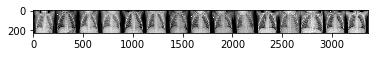

In [7]:
plt.imshow(Xtrain1[:,0:p2*15],cmap='gray');

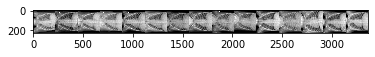

In [8]:
plt.imshow(Xtrain2[:, 0: p2*15],cmap='gray');

In [9]:
print('size of X(1) and X(2):')
print(X1.shape);
print(X2.shape);

size of X(1) and X(2):
(224, 224, 5216)
(224, 224, 5216)


#### a. Perform HOSVD with training data to obtain the Matrices $U, \Sigma, V$ in $XX^T = U\Sigma V^T$

$\tilde A$ is the first $\tilde p$ leading  eigenvectors in U,  
$\tilde B$ is the first $\tilde q$ leading  eigenvectors in V.  
Here, for simplicity, I prespecify $\tilde p=\tilde q = 3$

In [10]:
## HOSVD
Ua, Da, Va  = np.linalg.svd(Xtrain1 @ Xtrain1.T);
Ub, Db, Vb = np.linalg.svd(Xtrain2 @ Xtrain2.T);
q1=80; q2=80
A = Ua[:,0:q1];# 224 x 30
B = Ub[:,0:q2];# 224 x 30
print('size of A and B:')
print(A.shape);
print(B.shape);

size of A and B:
(224, 80)
(224, 80)


Then we have the $\tilde A_{224*3}, \tilde B_{224*3}$

#### b. With the initial $\tilde A, \tilde B$,  perform mPCA to obtain the optimized $\hat A, \hat B$

With the initial $\tilde A, \tilde B$, we can repeatedly update $\hat A, \hat B$, and calculate the new reconstruction error.  
The iteration will stop when the difference of reconstruction error is less than a small value (say, 0.0001)  
Note that reconstruction error = $\frac{1}{n}\sum_{i=1}^{n} ||X_i-\hat A\hat A^TX_i\hat B\hat B^T||^2_F$, where X is the training data

In [11]:
t=0; delta_0= 0.0001; delta=2*delta_0;
loss = 0
A_hat = A
q=q1;
bef_mpca = time.time()
while delta>delta_0:
    #### update B
    loss_old = loss # record the old loss
    sum = np.zeros(shape=(224,224))
    for i in range(5216):
        sum += (X[i].T@A_hat)@(A_hat.T@X[i])
    U1,S1,V1 = np.linalg.svd(sum)
    B_hat = U1[:,0:q]  
    #### update A
    sum = np.zeros(shape=(224,224))
    for i in range(5216):
        sum += (X[i]@B_hat)@(B_hat.T@X[i].T)
    U2,S2,V2 = np.linalg.svd(sum)
    A_hat = U2[:,0:q]  
    ### Compute reconstruction error
    loss = 0
    X_rescon = np.zeros(shape=(224,224,5216))
    for i in range(5216):
        X_rescon[:,:,i] = (A_hat@A_hat.T)@(X[i]@B_hat@B_hat.T)
        diff = X[i] - X_rescon[:,:,i]
        loss += np.sum(np.sum(np.square(diff), axis=1))/16
    delta = abs(loss-loss_old)
    print(delta)
aft_mpca = time.time()
time_mpca = aft_mpca-bef_mpca

10424.084582480727
0.049659848105875426
9.882440281216986e-06


The iteration stops and we obtain the optimized $\hat A, \hat B$

In [12]:
print('size of Ahat:');
print(A_hat.shape);
print('size of Bhat:');
print(B_hat.shape);

size of Ahat:
(224, 80)
size of Bhat:
(224, 80)


In [13]:
# 讀取測試資料
Xtest, Ytest = test_generator.next();
m = Xtest.shape[0];
Xtest = np.reshape(Xtest, [m, p1, p2]);

Then we can reduce training and testing data by the optimized $\hat A, \hat B$ and obtain the MPCA-Reduced core tensors.

In [14]:
# 對訓練資料和測試資料做降維
An = np.expand_dims(A_hat, 0); # --> [1,p1,q1]
An = np.tile(An, [n,1,1]); # --> [n,p1,q1]
AnT = np.transpose(An, (0,2,1)); # --> [n,q1,p1]
Bn = np.expand_dims(B_hat,0); # --> [1,p1,q1]
Bn = np.tile(Bn, [n,1,1]); # --> [n,p1,q1]
Xlow = AnT @ X @ Bn; # --> [n,q1,q2] #the core tensor
# 
Am = np.expand_dims(A_hat, 0); # --> [1,p1,q1]
Am = np.tile(Am, [m,1,1]); # --> [n,p1,q1]
AmT = np.transpose(Am, (0,2,1)); # --> [n,q1,p1]
Bm = np.expand_dims(B_hat,0); # --> [1,p1,q1]
Bm = np.tile(Bm, [m,1,1]); # --> [n,p1,q1]
Xtest_low = AmT @ Xtest @ Bm; # --> [n,q1,q2]
#
v = X_valid.shape[0];
Av = np.expand_dims(A_hat, 0); # --> [1,p1,q1]
Av = np.tile(Av, [v,1,1]); # --> [n,p1,q1]
AvT = np.transpose(Av, (0,2,1)); # --> [n,q1,p1]
Bv = np.expand_dims(B_hat,0); # --> [1,p1,q1]
Bv = np.tile(Bv, [v,1,1]); # --> [n,p1,q1]
Xvalid_low = AvT @ X_valid @ Bv; # --> [n,q1,q2]

print('size of Xlow and Xtest_low:');
print(Xlow.shape);
print(Xtest_low.shape);
print(Xvalid_low.shape);

size of Xlow and Xtest_low:
(5216, 80, 80)
(624, 80, 80)
(16, 80, 80)


## Implementation of Gradient Decsent

### Code Implementation

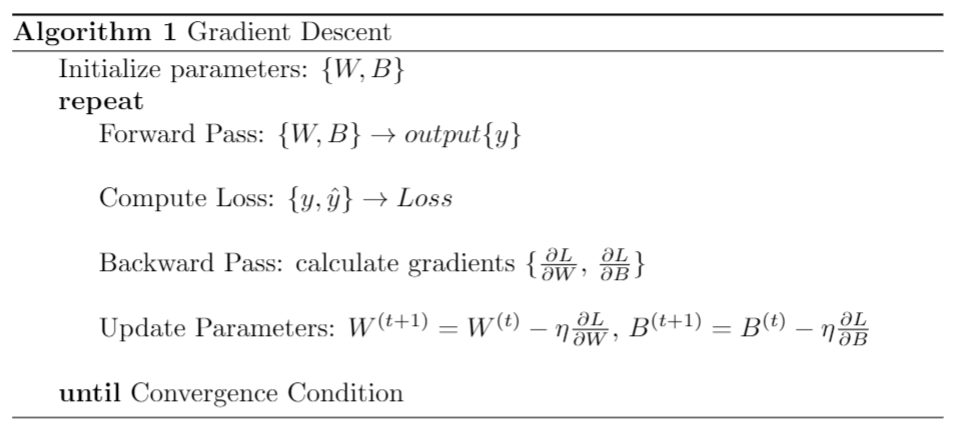

#### Parameters Initialization
given the number of  
1. dimension of inputvecotors
2. number of neurons in hidden layer
3. number of neurons in output layer

randomly generate the parameters vectors $W^{(1)}, B^{(1)}, W^{(2)}, B^{(2)}$with corresponding length.

In [15]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros([n_h, 1])
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros([n_y, 1])
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters

#### Forward Pass
given the initialized parameters and activation function, we can obtain the $Z^{(1)}$, $a^{(1)}$,  $Z^{(2)}$, $a^{(2)}$

In [16]:
def forwardpass(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.maximum(0,Z1)       # ReLU
    Z2 = np.dot(W2, A1) + b2
    A2 = 1/(1+np.exp(-Z2))      # Sigmoid
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

#### Cost(loss) Calculation
Now that you have computed $A^{[2]}$, which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

$$L = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

In [17]:
def compute_cost(A2, Y):
    m = Y.shape[0]   # number of calss
    
    #logprobs = np.multiply(np.log(A2), Y)
    #cost = - np.sum(np.multiply(np.log(A2), Y) + np.multiply(1-Y, np.log(1-A2))) / m
    cost = (1./m) * (-np.dot(Y,np.log(A2).T) - np.dot(1-Y, np.log(1-A2).T))
    
    cost = np.squeeze(cost)  # makes sure cost is the dimension we expect.
    return cost

#### Backward pass
Using the cache computed during forward propagation, you can now implement backward propagation.

In [18]:
def backwardpass(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    
    dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
    #dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))/np.log(10)
    
    temp_s = 1/(1+np.exp(-Z2))
    dZ2 = dA2 * temp_s * (1-temp_s)        # Sigmoid (back propagation)
    
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T,dZ2)
    
    # ReLU (back propagation)
    dZ1 = np.array(dA1, copy=True) # just converting dz to a correct object.
    dZ1[Z1 <= 0] = 0   # When z <= 0, you should set dz to 0 as well. 
    
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

#### Update parameters
Given the parameters, gradients, and learning rate $\eta$,  
we can update the parameters by $\theta^{(t+1)} = \theta^{(t)} - \eta*\frac{\partial L}{\partial \theta}$.

In [19]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters

In [20]:
def nn_model(X, Y, X_valid, Y_valid,n_h, num_iterations = 5000, learning_rate=0.08, print_cost = False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    costs = []
    costs_valid = []
    accuracies = []
    accuracies_valid = []
    np.random.seed(1)
    n_x = X.shape[0]
    n_y = 1
    table = pd.DataFrame(None, columns = ['Index','Loss' , 'Loss(valid)', 'Accuracy' , 'Accuracy(valid)'])
    # Initialize W1, b1, W2, b2
    parameters = initialize_parameters(n_x, n_h, n_y)
    #print("W1.shape: " + str(parameters["W1"].shape))
    #print("W2.shape: " + str(parameters["W2"].shape))
    for i in range(0, num_iterations+1):
        ## forward pass with training data
        A2, cache = forwardpass(X, parameters)
        ## cost function 
        cost = compute_cost(A2, Y)
        ## get gradient and update parameters
        grads = backwardpass(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)
        #### forward pass with validation data
        A2_val, cache_val = forwardpass(X_valid, parameters)
        ## cost 
        cost_valid = compute_cost(A2_val, Y_valid)
#         ## get gradient and update parameters
#         grads = backwardpass(parameters, cache_val, X_valid, Y_valid)
#         parameters = update_parameters(parameters, grads, learning_rate)
        if i % 200 == 0:
            ## get accuracy
            y_hat = np.zeros(X.shape[1])
            for j in range(len(y_hat)):
                y_hat[j] = 1 if A2[0,j]>0.5 else 0
            accuracy = np.mean(y_hat == Y)
            accuracies.append(accuracy)
            ## get accuracy (validation)
            y_hat_valid = np.zeros(X_valid.shape[1])
            for j in range(len(y_hat_valid)):
                y_hat_valid[j] = 1 if A2_val[0,j]>0.5 else 0
            accuracy_val = np.mean(y_hat_valid == Y_valid)
            accuracies_valid.append(accuracy_val)
            ###
            costs.append(cost)
            costs_valid.append(cost_valid)
            table = table.append({'Index' : i , 'Loss' : cost, 'Loss(valid)':cost_valid, 'Accuracy': accuracy, 'Accuracy(valid)': accuracy_val} , ignore_index=True)
            print("After interation {} - loss:{} - accuracy:{} - val_loss:{} - val_accuracy:{}".format(i, cost, accuracy, cost_valid, accuracy_val))
        if cost_valid < 0.0001:
            break    
    # The latest iteration.
#     print("Cost after iteration {}: {}".format(i, cost))
#     fig, ax = plt.subplots(ncols=2, figsize=(8,5))
#     plt.figure(num=1, figsize=(8,5))
#     plt.semilogy(costs)
#     plt.xlabel("Iterations")
#     plt.ylabel("Cost")
#     plt.title("Trainin Cost")
#     plt.show()
    
#     plt.figure(num=1, figsize=(8,5))
#     plt.semilogy(costs_valid)
#     plt.xlabel("Iterations")
#     plt.ylabel("Cost")
#     plt.title("Validation Cost")
#     plt.show()
    return parameters, table

In [21]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    # Forward propagation
    probas, caches = forwardpass(X, parameters)
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

#### Pre-processing (flatten the mpca-reduced tensor into a (pqxn) matrix

In [22]:
tmp = np.reshape(Xlow, [n, Xlow.shape[1]*Xlow.shape[2]], order='F')
x_train_mpca_30_flat = np.transpose(tmp, (1,0)) ##pqxn
tmp = np.reshape(Xtest_low, [Xtest_low.shape[0], Xtest_low.shape[1]*Xtest_low.shape[2]], order='F')
x_test_mpca_30_flat = np.transpose(tmp, (1,0)) ##pqxn
tmp = np.reshape(Xvalid_low, [Xvalid_low.shape[0], Xvalid_low.shape[1]*Xvalid_low.shape[2]], order='F')
x_valid_mpca_30_flat = np.transpose(tmp, (1,0)) ##pqxn

#### Model Fitting

In [23]:
parameters, table= nn_model(x_train_mpca_30_flat,X_class, x_valid_mpca_30_flat, X_valid_class,20, 
                             num_iterations=1200, learning_rate=0.005, print_cost=True)

After interation 0 - loss:0.6877673652500914 - accuracy:0.7429064417177914 - val_loss:0.6931421843867188 - val_accuracy:0.5
After interation 200 - loss:0.36014918960716424 - accuracy:0.8452837423312883 - val_loss:0.6760128453676332 - val_accuracy:0.625
After interation 400 - loss:0.23198398168867623 - accuracy:0.8945552147239264 - val_loss:0.39326114670769513 - val_accuracy:0.875
After interation 600 - loss:0.1662996854089313 - accuracy:0.9336656441717791 - val_loss:0.3221522421622367 - val_accuracy:0.9375
After interation 800 - loss:0.14850250581381208 - accuracy:0.942292944785276 - val_loss:0.2760019660389508 - val_accuracy:0.9375
After interation 1000 - loss:0.1196952529827098 - accuracy:0.9559049079754601 - val_loss:0.3298229919956151 - val_accuracy:0.9375
After interation 1200 - loss:0.11506412820746066 - accuracy:0.9576303680981595 - val_loss:0.3393901285312524 - val_accuracy:0.9375


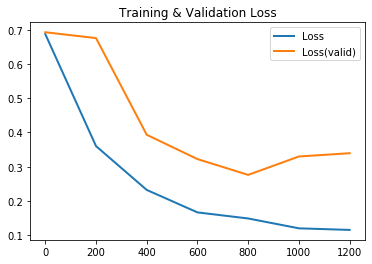

In [24]:
plt.plot( 'Index', 'Loss', data=table, marker='', linewidth=2)
plt.plot( 'Index', 'Loss(valid)', data=table, marker='', linewidth=2)
plt.title("Training & Validation Loss")
plt.legend();

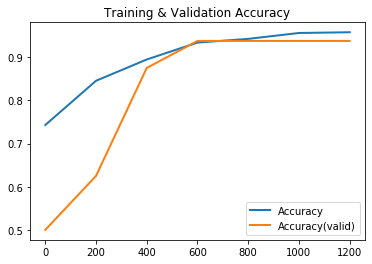

In [25]:
plt.plot( 'Index', 'Accuracy', data=table, marker='', linewidth=2)
plt.plot( 'Index', 'Accuracy(valid)', data=table, marker='', linewidth=2)
plt.title("Training & Validation Accuracy")
plt.legend();

#### Prediction with Testing data

In [26]:
print("Training accuracy:")
predictions_train = predict(x_train_mpca_30_flat, X_class, parameters)
print("Testing accuracy:")
predictions_test = predict(x_test_mpca_30_flat, X_test_class, parameters)

Training accuracy:
Accuracy: 0.9576303680981595
Testing accuracy:
Accuracy: 0.7564102564102564
